# Проектная работа. Разработка стратегии взаимодействия с клиентами фитнес-центра

##### Цель работы: провести анализ данных клиентов посетивших фитнес-центр, предсказать отток посетителей и разработать стратегию удержания клиентов.

##### Источник данных: данные предоставлены заказчиком исследования - фитнес-центром "Культурист-датасаентист"

##### Описание данных:

    'Churn' — факт оттока в текущем месяце;
    Текущие поля в датасете:
    Данные клиента за предыдущий до проверки факта оттока месяц:
    'gender' — пол;
    'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
     Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
     'Phone' — наличие контактного телефона;
     'Age' — возраст;
     'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
      Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
     'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
     'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
     'Group_visits' — факт посещения групповых занятий;
     'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
     'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
     'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

#### Содержание

Шаг 1. Импорт необходимых библиотек и загрузка

Шаг 2. Проведите исследовательский анализ данных (EDA)

Шаг 3. Постройте модель прогнозирования оттока клиентов

Шаг 4. Сделайте кластеризацию клиентов

Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

## Шаг 1. Импорт необходимых библиотек и загрузка 

In [1]:
# Баш-ячейка для апгрейда библиотеки seaborn
!pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)


In [2]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
# Загрузка датасета
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

## Шаг 2. Проведите исследовательский анализ данных (EDA)<a name="step2"></a>

##### Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения 

In [4]:
# Создадим функцию для изучения основной информации о датасете
def dataframe_info(column, data):
        display(data.sample(5))
        print(2*'\n')
        data.info()
        print(2*'\n')
        for column in data:
            print('Количество пропусков в столбце', column, ':', ((data[column].isna().sum()/len(data[column])*100).round()), '%')
            
        print('В датасете обнаружено {} дубликатов'.format(data.duplicated().sum()))

In [5]:
# Посмотрим на датасет
dataframe_info(gym_churn.columns, gym_churn)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1326,1,1,1,1,1,12,1,30,341.768106,12.0,2,0.000000,0.000000,0
1698,0,0,1,0,1,1,0,26,62.024658,1.0,1,2.513596,2.299249,1
3061,1,1,1,1,0,6,0,32,262.947060,5.0,3,2.283966,2.349141,0
1753,0,1,0,0,1,1,1,32,246.601288,1.0,3,1.308161,1.279804,0
2741,1,1,1,1,1,6,1,29,66.826979,5.0,1,1.168160,0.000000,1





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB



Количество пропусков в столб

##### Промежуточный вывод: получен датасет из 14 столбцов и 4000 строк. Пропусков и дубликатов в данных не обнаружено. Можно приступать к анализу.

In [6]:
# С заглавными буквами в названии столбцов работать неудобно, так что уберем их
gym_churn = gym_churn.rename(str.lower, axis = 'columns')

In [7]:
# Посмотрим на средние значения и стандартные отклонения для всех признаков
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


#### Промежуточный вывод: по полученным средним значениям можно составить портрет среднестатистичечкого посетителя: человек возрастом 26-32 лет,  посещает фитнес-центр 1-3 раза в неделю, является посетителем уже более 3-х месяцев, проживает или работает недалеко от фитнес-центра, благочклонно относится к сопутствующим услугам и время окончания его абонемента составляет в среднем 4 месяца.

##### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [8]:
mean_char = gym_churn.groupby('churn').mean().reset_index()
display(mean_char)

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


##### Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

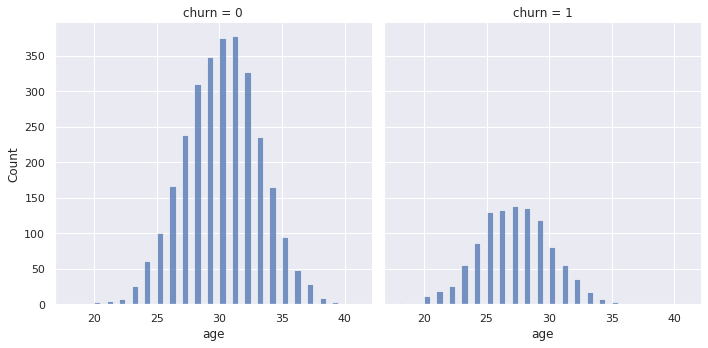

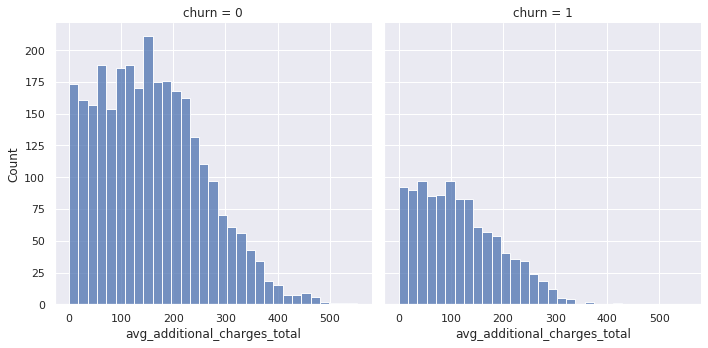

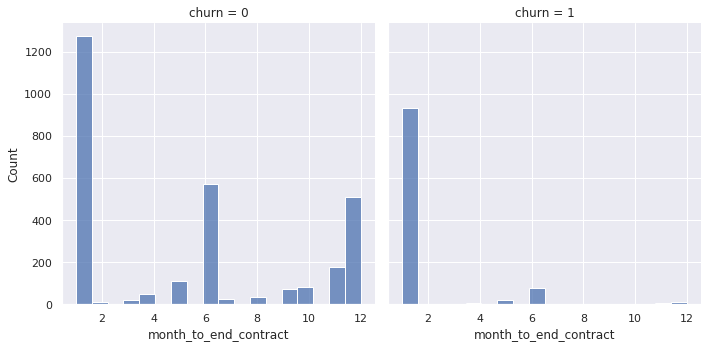

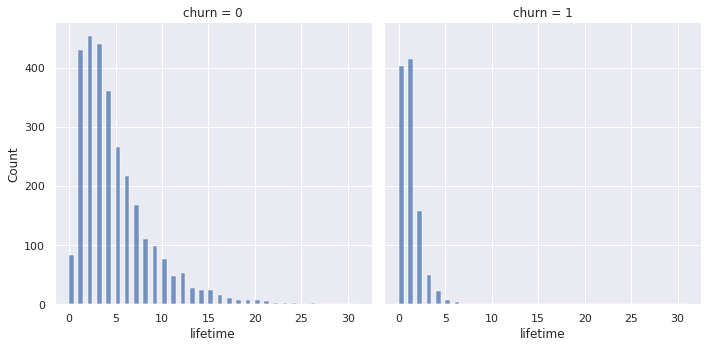

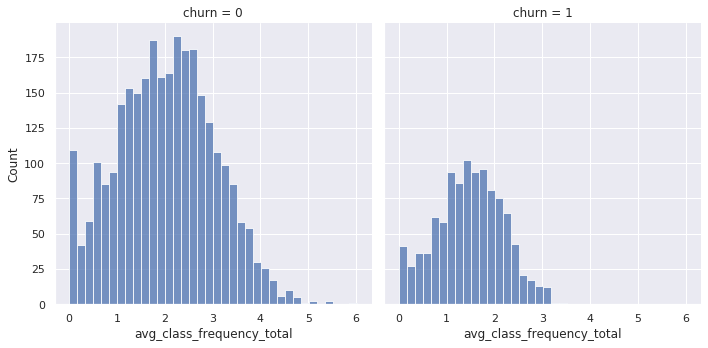

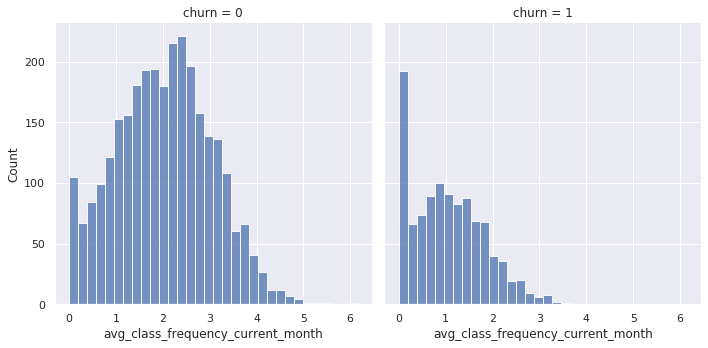

In [9]:
# Построим распределения количественных признаков
for i in gym_churn[['age',
                    'avg_additional_charges_total',
                    'month_to_end_contract',
                    'lifetime',
                    'avg_class_frequency_total',
                    'avg_class_frequency_current_month']]:
    sns.set_theme(style="darkgrid")
    sns.displot(
        gym_churn, x=gym_churn[i], col="churn")
    

#### Промежуточный вывод: посмотрев на распределения количественных признаков можно отметить, что для посетителей, которые покинули фитнес-центр характерны следующие моменты: низкая посещаемость - 1-2 раза в неделю, за последний месяц много не посетивших ни разу, чаще всего покупается абонементы на 1-2 месяца, низкая заинтересованность в приобретении других услуг фитнес-центра.

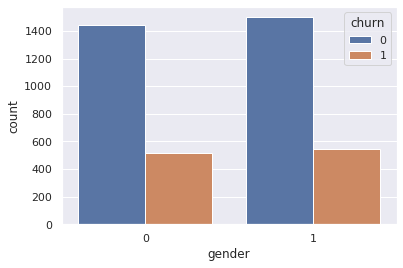

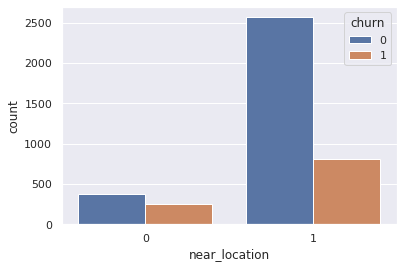

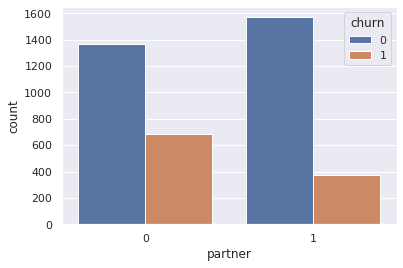

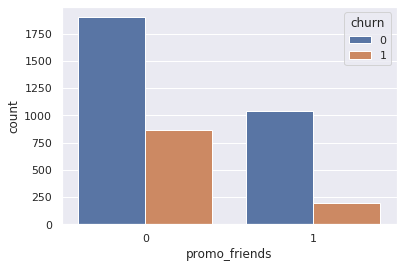

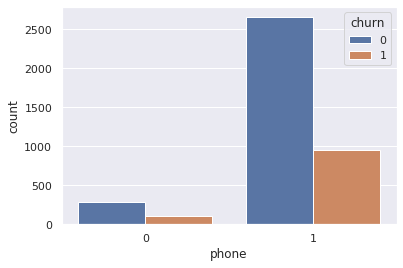

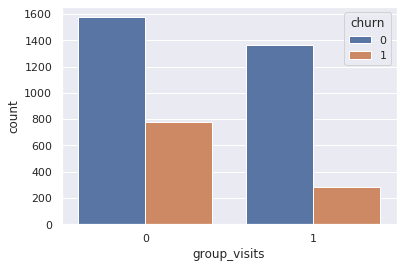

In [10]:
# Построим столбчатые гистограммы для категориальных признаков
for j in gym_churn[['gender',
                    'near_location',
                    'partner',
                    'promo_friends',
                    'phone',
                    'group_visits']].columns:
    sns.set_theme(style="darkgrid")
    sns.countplot(data=gym_churn, x=gym_churn[j], hue='churn')
    plt.show()

#### Промежуточный вывод: посмотрев на столбчатые гистограммы для категориальных признаков можно отметить, что для посетителей, которые покинули фитнес-центр характерны следующие моменты: существенно влияет близость фитнес-центра к дому или офису, участие в партнерской программе снижает отток пользователей, благоприятно влияет на отток посетителей акция "приведи друга" и проведение групповых занятий. Наличие контактного телефона увеличивает отток пользователей, но и вместе с тем повышает количество посетителей.

##### Постройте матрицу корреляций и отобразите её.

In [11]:
# Создадим матрицу корреляции
corr_mtx = gym_churn.corr()

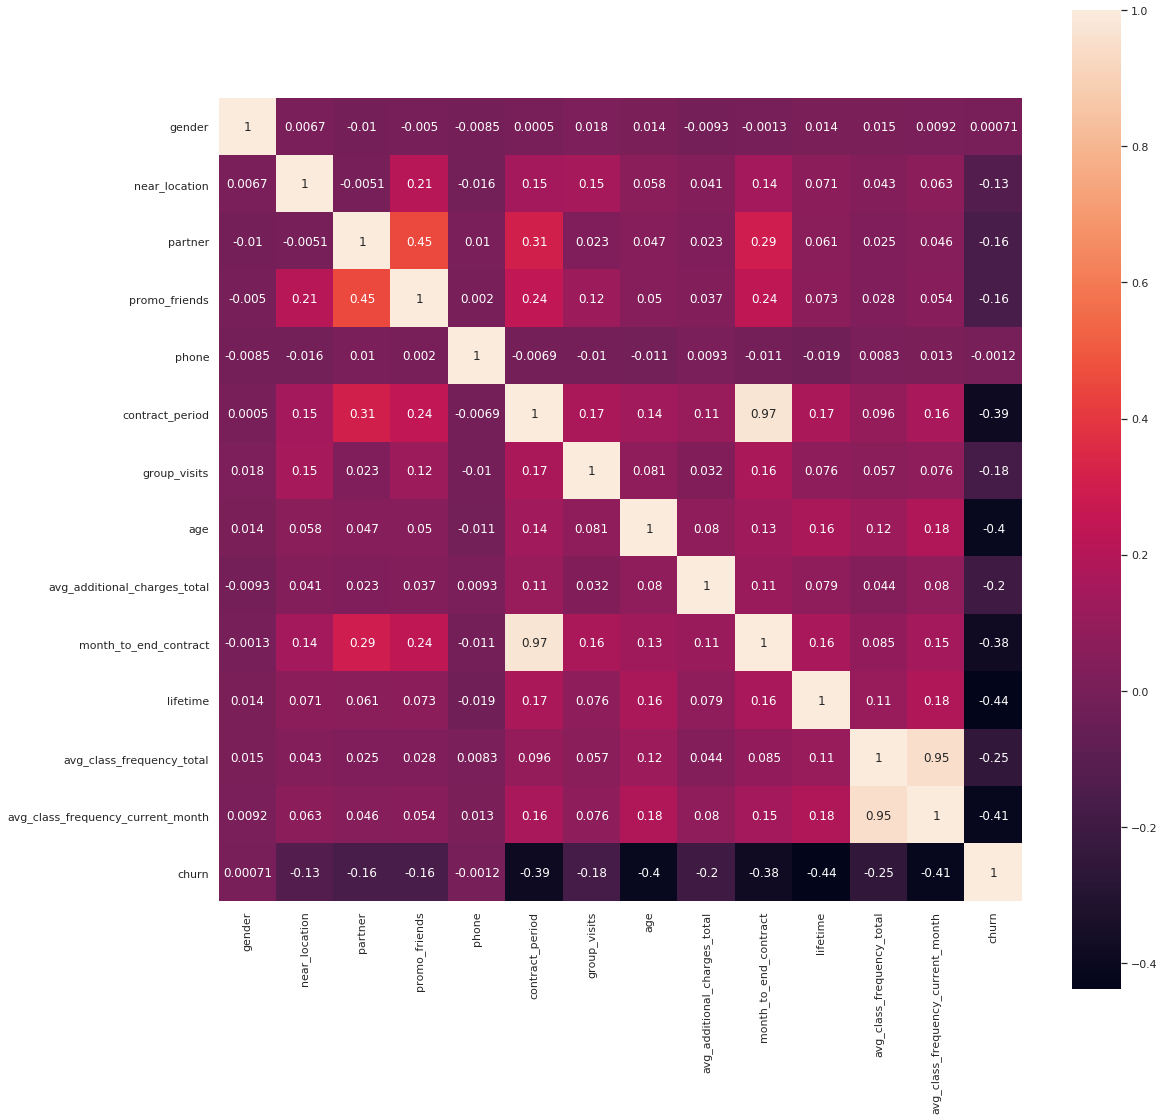

In [12]:
# Визуализируем ее
plt.figure(figsize=(18, 18))
sns.heatmap(corr_mtx, annot=True, square=True)
plt.show()

#### По матрице корреляции можно отметить, что две пары признаков имеют высокую корреляцию (>0.9):  срок до окончания действующего абонемента коррелирует с длительностью текущего действующего абонемента; и средняя частота посещений в неделю за весь срок действия абонента коррелирует с частотой посещений в неделю за последний месяц.

## Шаг 3. Постройте модель прогнозирования оттока клиентов

##### Постройте модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

##### Разбейте данные на обучающую и валидационную выборку

In [13]:
# Выделим матрицу признаков и вектор целевого признака
y = gym_churn['churn']
X = gym_churn.drop('churn', axis = 1)

In [14]:
# Разбиение на тестовую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [15]:
# Обзовем модели для обучения
model_regression = LogisticRegression(random_state=0, solver='liblinear')
model_forest = RandomForestClassifier(random_state=0, n_estimators=10)

In [16]:
# Обучение моделей
model_regression.fit(X_train, y_train)
model_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [17]:
# сделаем предсказания с помощью моделей
y_pred_reg = model_regression.predict(X_test)
y_pred_forest = model_forest.predict(X_test)

##### Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели. Какая модель показала себя лучше на основании метрик?

In [18]:
# Посчитаем метрики модели полученной логистической регрессией
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred_reg)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred_reg)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred_reg)))


Accuracy: 0.93
Precision: 0.86
Recall: 0.83


In [19]:
# Посчитаем метрики модели полученной случайным лесом
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred_forest)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred_forest)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred_forest)))

Accuracy: 0.91
Precision: 0.83
Recall: 0.78


#### Промежуточный вывод: построены и обучены 2 модели бинарной классификации клиентов: модель логистической регресии и модель "случайного леса". Посчитаны метрики "Доля правильных ответов" (accuracy), "точность" (precision) и "полнота" (recall) для оценки качества обученных моделей. На основании полученных значений указанных метрик модель логистической регрессии показывает себя лучше нежели модель "случайного леса".

## Шаг 4. Сделайте кластеризацию клиентов

##### Стандартизируйте данные.

In [20]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [21]:
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

##### Постройте матрицу расстояний на стандартизованной матрице признаков и нарисуйте дендрограмму. На основании полученного графика предположите, какое количество кластеров можно выделить.

In [22]:
# Построение матрицы расстояний
X_sc = scaler.fit_transform(X)
linked = linkage(X_sc, method = 'ward')

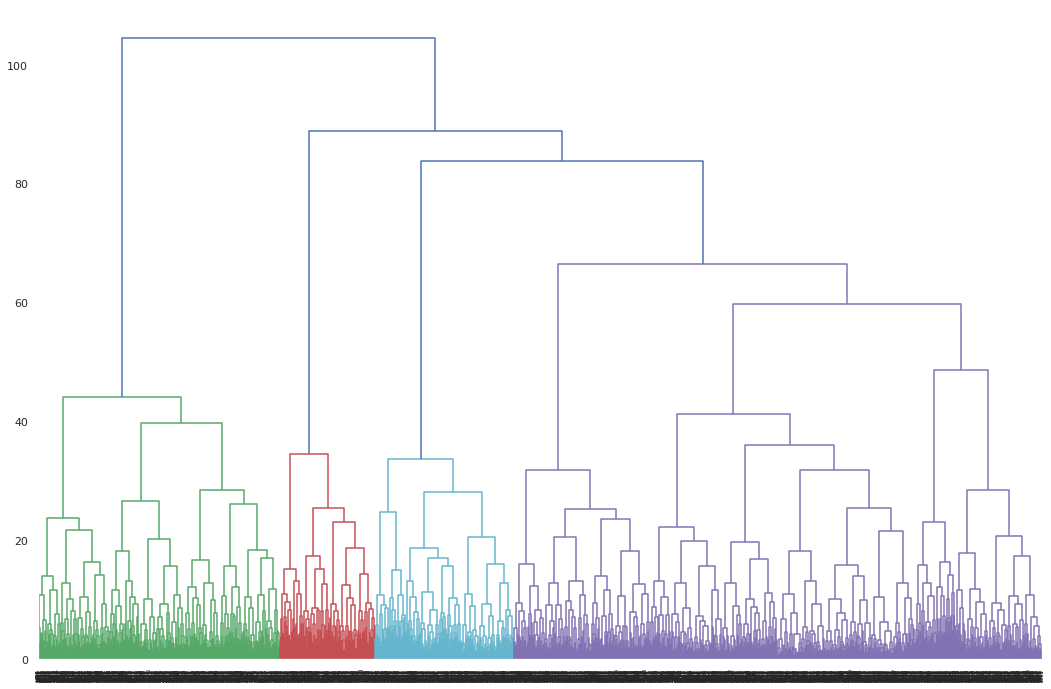

In [23]:
# Построим дендрограмму признаков
plt.figure(figsize=(18, 12))  
dendrogram(linked, orientation='top')
plt.xticks(rotation=90)
plt.show() 

##### Промежуточный вывод: по виду полученного графика предполагаем, что можно выделить 4 кластера посетителей.

##### Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. 

In [24]:
# Задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)
# Прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

In [25]:
# Сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels
# Выводим статистику по средним значениям наших признаков по кластеру
gym_churn.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


#### Промежуточный вывод: по средним значениям признаков по кластерам можно сразу отметить, что:

#### 1) в кластере 2 нет ни одного посетителя, у которого работа или дом находтся близко к фитнес-центру, что уже является высокой веротностью к оттоку;


#### 2) в кластерах 2 и 3 самое маленькое значение срока действия абонемента, поэтому его можно отнести к "группе риска";

#### 3) в кластерах 2 и 3 значение продаж от других услуг фитнес-центра ниже, чем в остальных кластерах - возможно посетители дожидаются окончания действия абонемента и не собираются его продлевать, поэтому им и не интересны сопутствующие услуги;


#### 4) в кластерах 2 и 3 самые низике значения средних величин сроков до окончания абонемента и времени занятий от момента первого обращения (абонемент взят на короткий срок, что уже должно насторожить отдел по работе с клиентами), а так же самые низкие значения посещаемости за неделю.

#### Кластеры 2 и 3 можно отнести к кластерам с повышенной вероятностью оттока клиентов.

##### Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

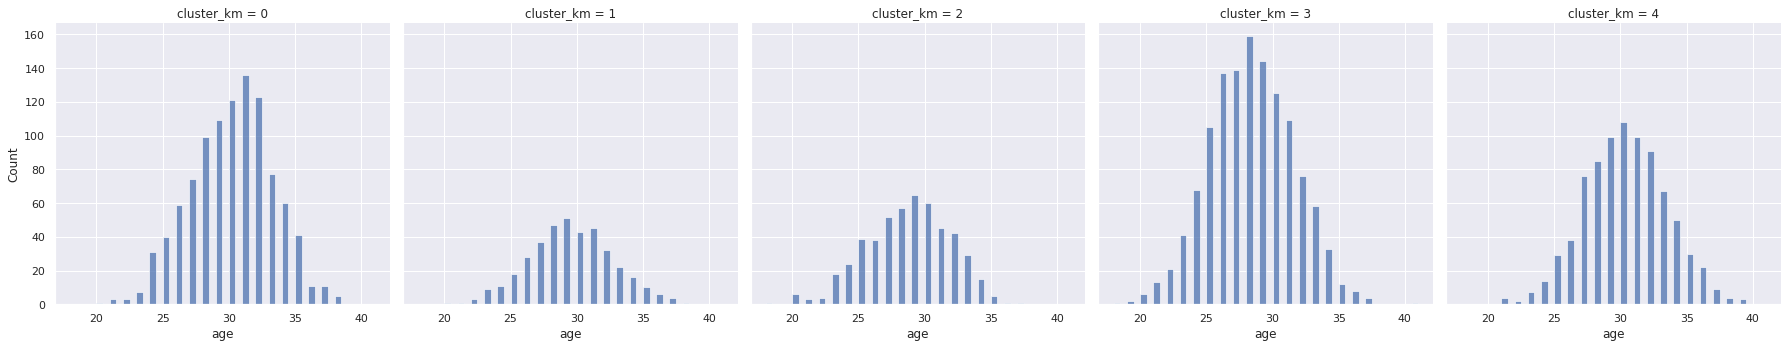

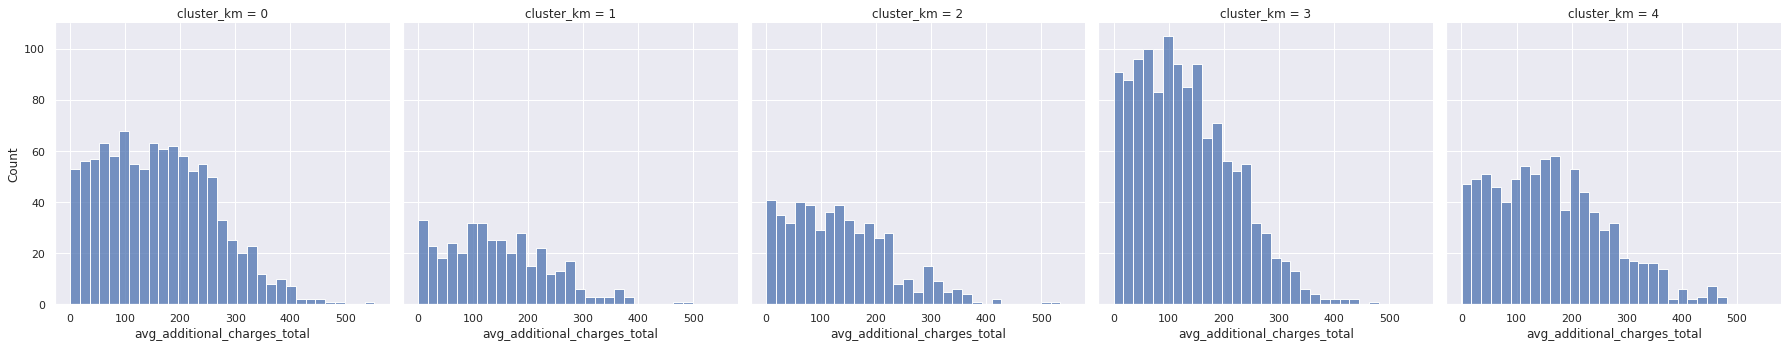

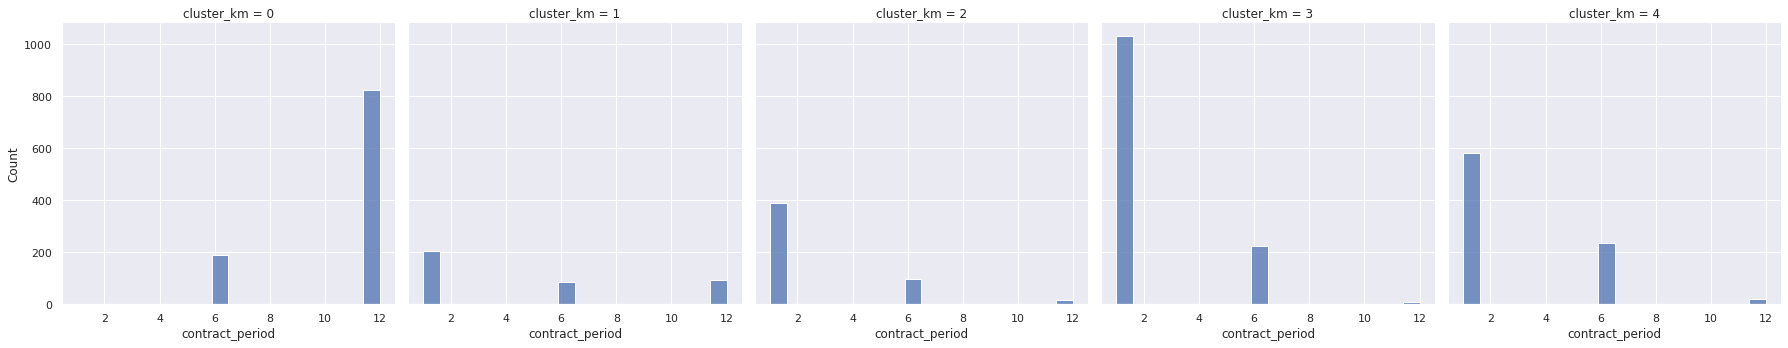

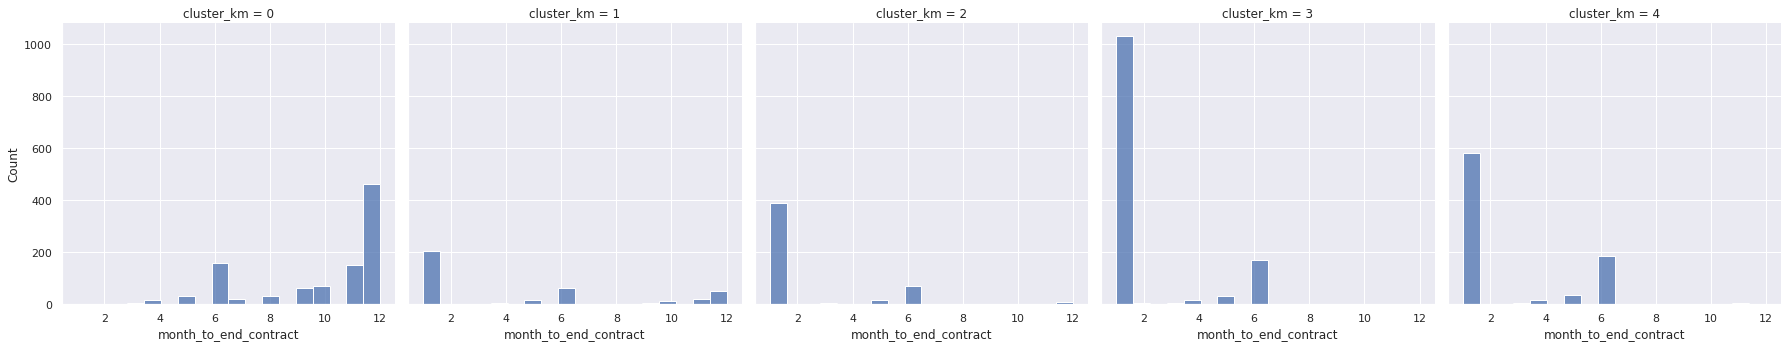

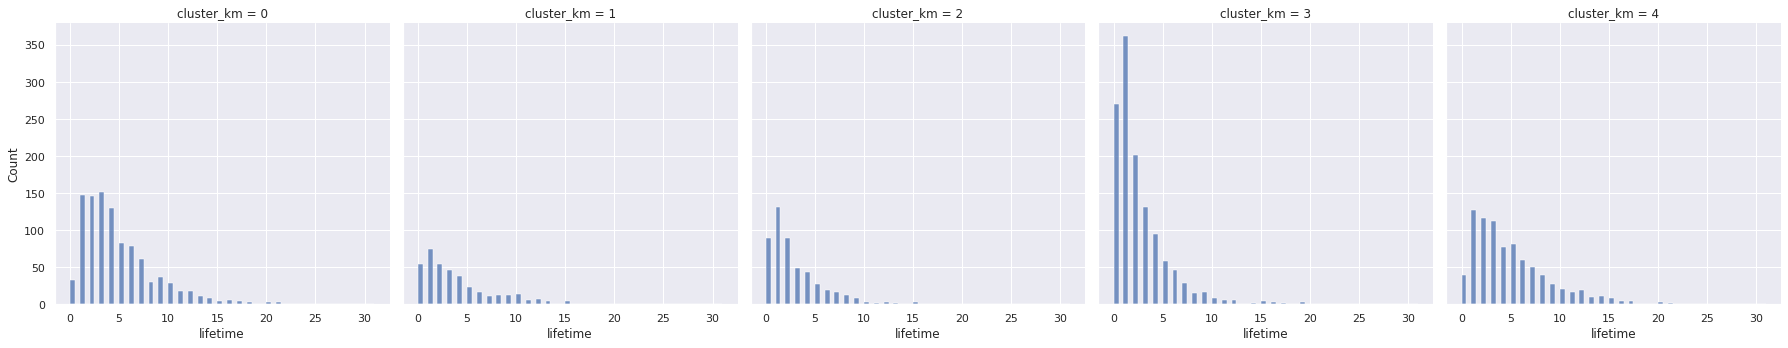

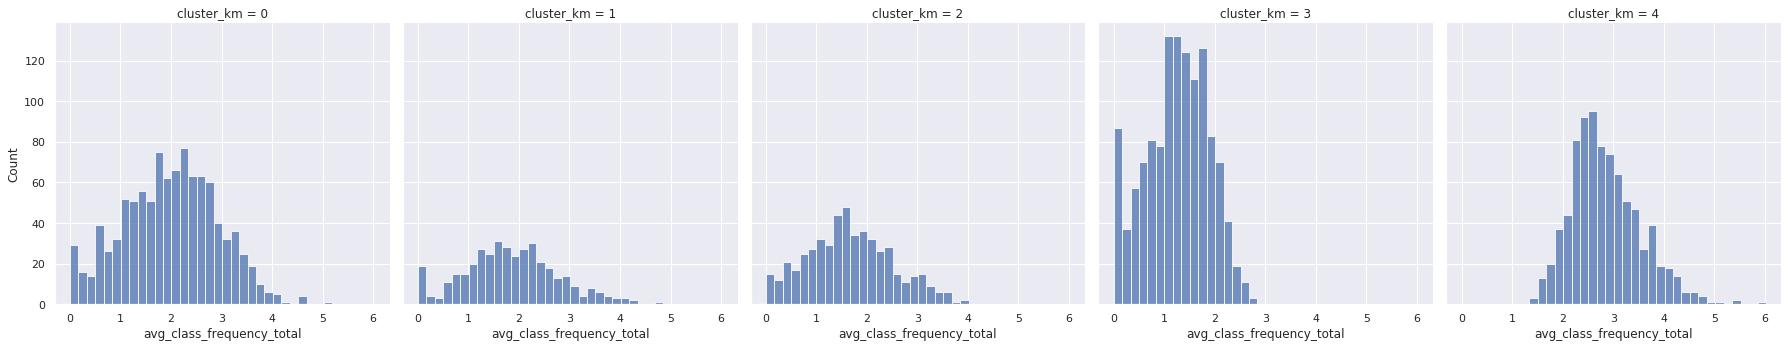

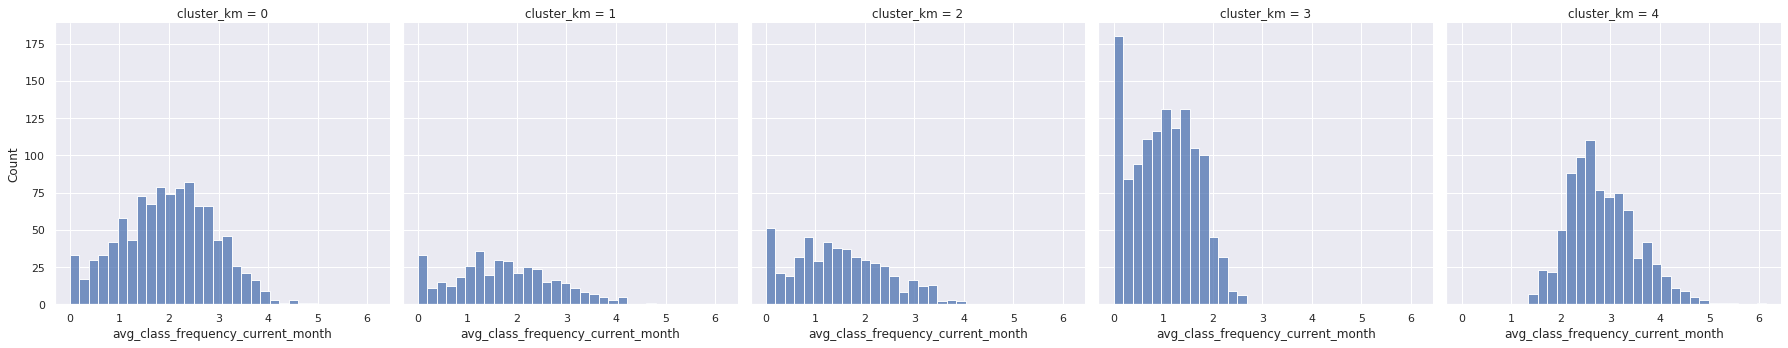

In [26]:
# Строим распределения для количественных признаков
for i in gym_churn[['age',
                    'avg_additional_charges_total',
                    'contract_period',
                    'month_to_end_contract',
                    'lifetime',
                    'avg_class_frequency_total',
                    'avg_class_frequency_current_month'
                    ]]:
    sns.set_theme(style="darkgrid")
    sns.displot(
        gym_churn, x=gym_churn[i], col="cluster_km")

#### Промежуточный вывод: распределения количественных признаков подтверждают выводы сделанные выше для кластера №2. Для кластера №3 выводы схожи, кроме признака "средняя выручка с продажи сопутствующих услуг". Различия в выводах объясняется тем, что распределения большинства признаков не нормальные и оценивать признаки только лишь по средним значениям будет некорректно.

#### Стоит также обратить внимание на кластер №1: он получился самый малочисленный среди всех кластеров, следовательно отток пользователей в количественном выражении может быть и меньше остальных, но в относительном может быть значителен.


#### По распределению признаков можно сделать вывод, что стоит обратить внимание на кластеры пользователей 1, 2 и 3, как склонных к оттоку.

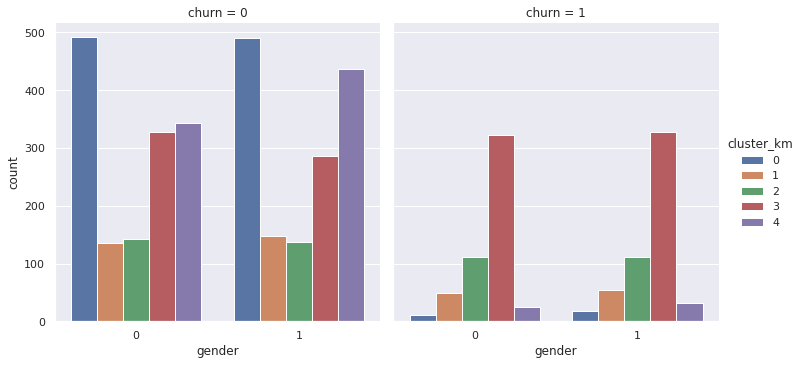

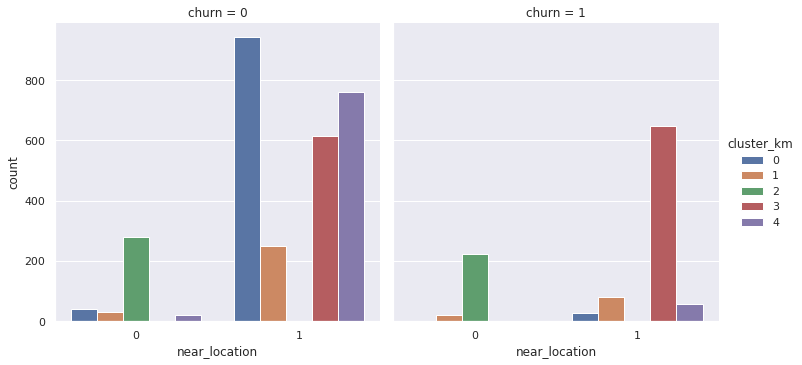

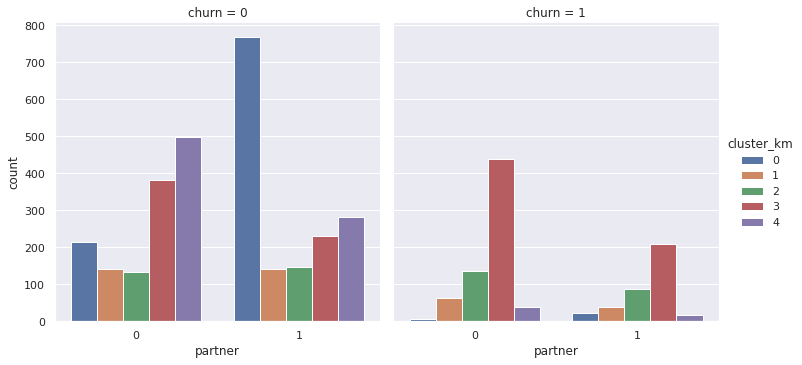

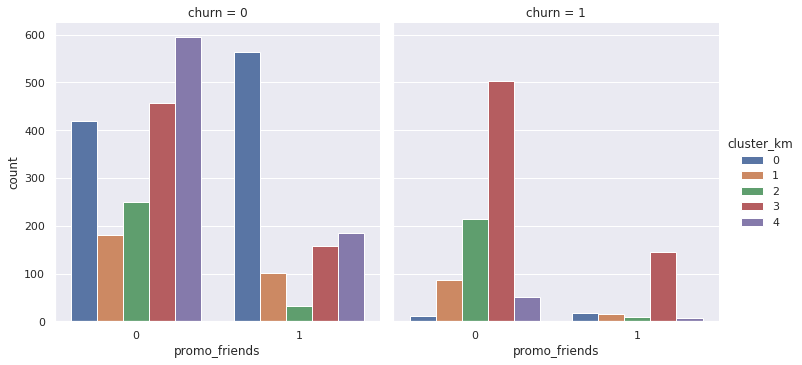

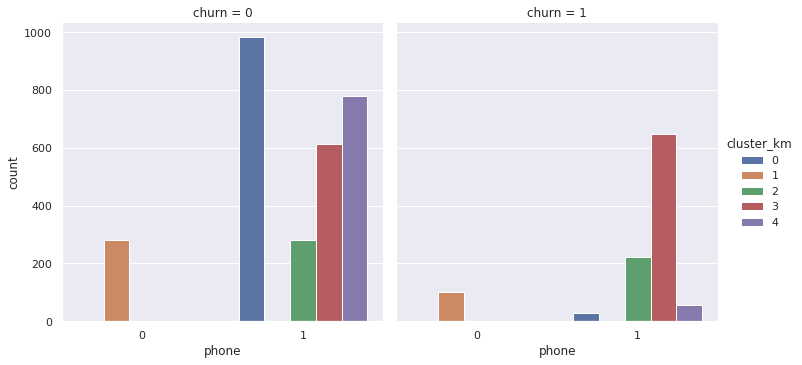

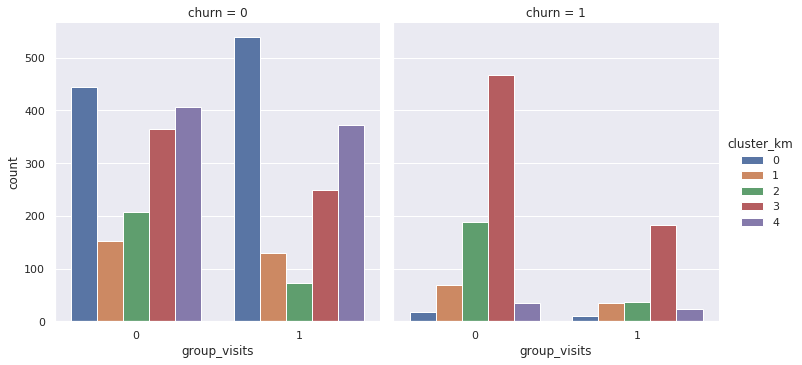

In [27]:
# Построим столбчатые гистограммы для категориальных признаков по кластерам
for j in gym_churn[['gender',
                    'near_location',
                    'partner',
                    'promo_friends',
                    'phone',
                    'group_visits'
                    ]].columns:
    #sns.set_theme(style="darkgrid")
    #plt.figure(figsize=(12,12))
    sns.catplot(data=gym_churn, x=j, hue='cluster_km', col='churn', kind='count')
    plt.show()

#### Промежуточный вывод: по столбчатым гистограммам категориальных признаков можно отметить следующие особенности: для кластера 3 важно наличие фитнес-центра поблизости от дома или места работы, для кластеров 2 и 3 важно наличие партнерской программы, значительно повышает отток посетителй наличие контактного телефона, для кластера 3 важно наличие групповых занятий и наличие акции "приведи друга".

##### Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [28]:
# посчитаем долю оттока пользователей покластерно
churn_rate = gym_churn.groupby('cluster_km')['churn'].mean()

In [29]:
display(churn_rate)

cluster_km
0    0.027695
1    0.267532
2    0.443564
3    0.514263
4    0.068100
Name: churn, dtype: float64

Для подсчета доли оттока посетителей использована аггрегирующая функция .mean(), поскольку для бинарного признака такой подсчет математически совпадает с классическим подсчетом доли оттока.

#### Промежуточный вывод:по полученным значениям доли оттока можно предположить, что кластеры пользователей 0 и 4 надежны - доля оттока 2 и 6% посетителей соответственно, кластер №1 требует к себе внимания - доля оттока 27% пользователей, и кластеры 2 и 3 близки к катастрофе - примерно половина (44 и 51%) пользователей склонны к оттоку.

## Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

#### По итогам проведенного анализа и применения модели кластеризации K-means можно сделать следующие выводы:

    1) надежными считаются кластеры 0 и 4 (менее 10% оттока пользователей);
    2) над кластером 1 стоит поработать (25% оттока пользователей);
    3) кластеры 2 и 3 достойны самого пристального внимания (более 44% оттока пользователей).
    
#### Отделу по работе с персоналом можно сделать следующие рекомендации:
    1) если это возможно провести опросы посетителей об их предпочтениях при посещении фитнес-центра (это поможет повысить среднюю посещаемость в неделю или сгладить некие углы и без вских моделей :)))
    2) открыть еще несколько филиалов фитнес-центра, чтобы снизить отток пользователей кластера 2;
    3) проанализировать цены на абонементы, провести акционные продажи (например дать хорошую скидку при приобретении абонемента на 3 месяца и более)
    4) наращивать количество компаний-партнёров (это даст финансовую мотивацию большему количеству посетителй);
    5) увеличение количества групповых занятий также предположительно благотворно скажется на посещаемости и приведет к уменьшению оттока;
    6) использование акции "приведи друга" снижает отток пользователей;
    7) наличие контактного телефона одновременно повышает общее количество посетителей и отток пользователей, так что с этой опцией стоит быть аккуратнее и по возможности провести дополнительное исследование (например, как относятся посетители к рекламным рассылкам).